# Numerical solution of the Poisson problem in Julia

We will solve the Poisson problem:

$$
\begin{align*}
- \Delta u(x,y) &= f(x,y) \quad \text{in } \Omega \\
u(x,y) &= bc \quad \text{on } \partial \Omega
\end{align*}
$$

The finite difference discretisation yields:
$$
(\frac{2}{\Delta x^2} + \frac{2}{\Delta y^2}) u_{i,j} - \frac{1}{\Delta x^2}u_{i+1,j} - \frac{1}{\Delta x^2}u_{i-1,j} - \frac{1}{\Delta y^2}u_{i,j+1} - \frac{1}{\Delta y^2}u_{i,j-1} = f_{i,j}
$$

To be turned into matrix form $A U = F$, where:
- $A$ is the stiffness matrix, 
- $U$ is the desired solution in vector form,
- $F$ the right-hand side obtained by collecting values of $f$ while taking into account the boundary condition whenever a neighbor $(i+1,j)$, $(i-1,j)$, $(i,j+1)$, $(i,j+1)$ falls on the boundary.

## Geometry

First things first, we need to define the geometry, which in our case, is a simple rectangle on a structured grid.

In [1]:
## A simple rectangle regularly discretised
mutable struct Geometry
    Lx::Float64
    Ly::Float64
    Nx::Int64
    Ny::Int64
end

 While it is easier for the humman eye to visualize things on a **2D plane**, it is more practical to present quantities of interest in **matrix form**, and even better, in **vector form** for linear algebra. In all that follows, we will use the Matrix form, which happens to match the way Julia stores its matrices: **column-first**.

![Image Test](geometry.png)

A few extra functions are needed to assure the transformation from one form to another.

In [2]:
## Reshapes a vector into a Julia-ready matrix for representation
vectomat(U::Vector{T}, N::Int64, M::Int64) where {T<:Number} = reshape(U, (N,M))

## Flattens a matrix into a Julia-ready vector for computation
mattovec(u::Matrix{T}) where {T<:Number} = vec(u)

## Arranges a Julia-ready matrix into a 2D tensor suitable for human visualisation
matto2d(u::Matrix{T}) where {T<:Number} = reverse(permutedims(u), dims=1)

matto2d (generic function with 1 method)

## Boundary conditions

Upon creating a separate structure to contain our Poisson problem's parameters, we must define a function to set the desired boundary condition. Additionnaly, we need a function to identify where a point sits on a grid: west, south, east, north or inside.

In [3]:
## A struct to hold out Poisson problem attributes
mutable struct Poisson
    bc:: Float64
    u:: Matrix{Float64}
    f:: Matrix{Float64}
end

In [4]:
## Sets a boundary condition all around a matrix
function setbc(u::Matrix{T}, bc::Float64, g::Geometry) where {T<:Number}
    u[1,:] .= bc
    u[g.Nx+1,:] .= bc
    u[:, 1] .= bc
    u[:, g.Ny+1] .= bc
    return nothing
end

setbc (generic function with 1 method)

In [5]:
## Initiate a Poisson problem
function initpoisson(g::Geometry; bc::Float64=1.0, fval::Float64=1.0)
    u = zeros(Float64, (g.Nx+1,g.Ny+1))
    setbc(u, bc, g)
    f = fill(fval, (g.Nx+1,g.Ny+1))
    return Poisson(bc, u, f)
end

initpoisson (generic function with 1 method)

In [6]:
## Deternimes location of a given point in a rectangle geometry
## N.B. Assumes matrix form (Ny,Nx), not 2D plane form (Nx,Ny) obtained by rotation
function isonboundary(i::Int64, j::Int64, g::Geometry):AbstractString
    if j==1 
        return "west"
    elseif i==g.Nx+1
        return "south"
    elseif j==g.Ny+1
        return "east"
    elseif i==1
        return "north"
    else
        return "inside"
    end
end

isonboundary (generic function with 1 method)

## Solving the problem

We will now assemble the stiffness matrix $A$ and the right hand side $F$. The key insight here is that if a neighboring point is not "inside" the domain, then its contribution should be added to $F$, instead of $A$. When doing so, one should'nt forget to multiply said contribution by the boundary condition's value on that side.

In [7]:
## Solve a Laplave problem
function solvepoisson(l::Poisson, g::Geometry)
    n = (g.Nx-1)*(g.Ny-1)
    A = zeros(Float64, (n,n))
    F = mattovec(l.f[2:g.Nx, 2:g.Ny])

    Δx = g.Lx/g.Nx
    Δy = g.Ly/g.Ny
    val1 = 1.0/(Δx^2)
    val2 = 1.0/(Δy^2)
    val3 = 2.0 * (val1+val2)

    bcvals = Dict("south"=>val1, "east"=>val2, "north"=>val1, "west"=>val2)

    for i in 2:g.Nx, j in 2:g.Ny
        global_id = (i-1) + (j-2)*(g.Nx-1)
        A[global_id, global_id] = val3

        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        for (ix, jy) in neighbors
            b_name = isonboundary(ix, jy, g)
            if b_name == "inside"
                if ix==i-1
                    A[global_id, global_id-1] = -val1
                elseif ix==i+1
                    A[global_id, global_id+1] = -val1
                elseif jy==j-1
                    A[global_id, global_id-g.Nx+1] = -val2
                elseif jy==j+1
                    A[global_id, global_id+g.Nx-1] = -val2
                end
            else
                F[global_id] += bcvals[b_name] * l.u[ix,jy]
            end
        end
    end

    ## Print constructed quantities
    # show(stdout, "text/plain", A)
    # show(stdout, "text/plain", F)

    ## Solve linear system
    U = A\F
    l.u[2:g.Nx, 2:g.Ny] = vectomat(U, g.Nx-1, g.Ny-1)

    return nothing
end

solvepoisson (generic function with 1 method)

## Visualization

This is the easiest step. When plotting a 3D surface in Julia, it is important to remember that Julia stores matrices column-first.

In [8]:
using Plots

## visualize Poisson problem's solution
function visualizepoisson(l::Poisson, g::Geometry)
    ## Problem parameters
    println("\n----Poisson problem parameters----")
    println("Boundary condition: ", l.bc)
    println("Right hand side:    ", l.f[1,1])

    ## Display solution in a 2D plane
    println("\n\n----Numerical solution----")
    flush(stdout)
    display(matto2d(l.u))

    ## Construct plot data: y axis first, then x axis (Julia convention)
    x=range(0,g.Lx,length=g.Nx+1)
    y=range(0,g.Ly,length=g.Ny+1)
    data = [l.u[i,j] for j in 1:g.Ny+1, i in 1:g.Nx+1]

    title = "Numerical solution of the Poisson problem"
    plot(x, y, data, st=:surface, camera=(30,30), xlabel="x", ylabel="y", zlabel="u", title=title)
end

visualizepoisson (generic function with 1 method)

Finallly, let's initialize our problem and run it !


----Poisson problem parameters----
Boundary condition: 

1.0
Right hand side:    2.0


----Numerical solution----


51×101 Matrix{Float64}:
 1.0  1.0      1.0      1.0      1.0      …  1.0      1.0      1.0      1.0
 1.0  1.00099  1.00185  1.00261  1.0033      1.00261  1.00185  1.00099  1.0
 1.0  1.00173  1.0033   1.00473  1.00604     1.00473  1.0033   1.00173  1.0
 1.0  1.00234  1.0045   1.00651  1.00837     1.00651  1.0045   1.00234  1.0
 1.0  1.00286  1.00554  1.00805  1.0104      1.00805  1.00554  1.00286  1.0
 1.0  1.00332  1.00645  1.00941  1.0122   …  1.00941  1.00645  1.00332  1.0
 1.0  1.00372  1.00726  1.01061  1.0138      1.01061  1.00726  1.00372  1.0
 1.0  1.00409  1.00798  1.01169  1.01523     1.01169  1.00798  1.00409  1.0
 1.0  1.00441  1.00863  1.01267  1.01653     1.01267  1.00863  1.00441  1.0
 1.0  1.00471  1.00922  1.01355  1.01769     1.01355  1.00922  1.00471  1.0
 ⋮                                        ⋱                             ⋮
 1.0  1.00441  1.00863  1.01267  1.01653     1.01267  1.00863  1.00441  1.0
 1.0  1.00409  1.00798  1.01169  1.01523     1.01169  1.00798  1.0

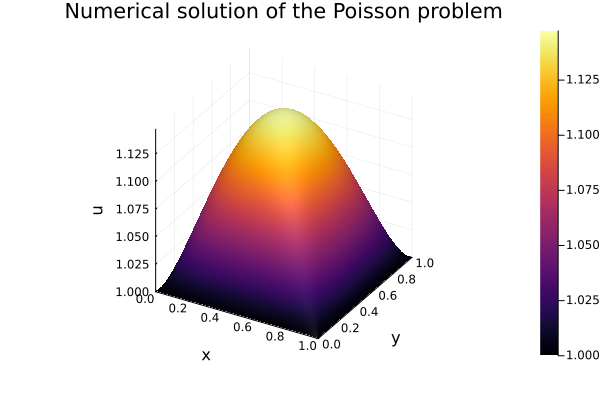

In [9]:

### Run the code in a function: no global variables !
function main()
    geo = Geometry(1,1,100,50)
    pb = initpoisson(geo; bc=1.0, fval=2.0)
    solvepoisson(pb, geo)
    visualizepoisson(pb, geo)
end

main()